In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import cv2
from numpy.random import randn
import os
import seaborn as sns
import keras
from keras.models import load_model
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Conv2D, Reshape, Input, Conv2DTranspose, Activation, LeakyReLU, BatchNormalization, Dropout, Resizing
from keras.losses import BinaryCrossentropy
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')

# config
noise_dimension = 100
batch_size = 64
width, height, channels = 200, 200, 1

# Connect Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Path to the dataset
main_dir = '/content/drive/MyDrive/Healthy'

# loading the dataset => resize images to 128*128*3
images = []
for i in os.listdir(main_dir):
    img_path = os.path.join(main_dir, i)
    print(f"Loading image: {img_path}")

    img = cv2.imread(img_path)

    # Check if the image was loaded successfully
    if img is None:
        print(f"Error loading image: {img_path}")
        continue

    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (200, 200))
    images.append(img)

dataset = np.array(images)

print(dataset.shape)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading image: /content/drive/MyDrive/Healthy/image_007.png
Loading image: /content/drive/MyDrive/Healthy/image_004.png
Loading image: /content/drive/MyDrive/Healthy/image_001.png
Loading image: /content/drive/MyDrive/Healthy/image_003.png
Loading image: /content/drive/MyDrive/Healthy/image_005.png
Loading image: /content/drive/MyDrive/Healthy/image_002.png
Loading image: /content/drive/MyDrive/Healthy/image_006.png
Loading image: /content/drive/MyDrive/Healthy/image_029.png
Loading image: /content/drive/MyDrive/Healthy/image_028.png
Loading image: /content/drive/MyDrive/Healthy/image_015.png
Loading image: /content/drive/MyDrive/Healthy/image_010.png
Loading image: /content/drive/MyDrive/Healthy/image_008.png
Loading image: /content/drive/MyDrive/Healthy/image_023.png
Loading image: /content/drive/MyDrive/Healthy/image_025.png
Loading image: /content/drive/M

(365, 200, 200)


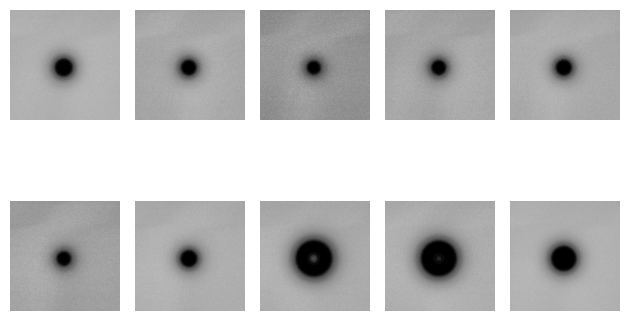

No error till now


In [2]:
X_train = dataset

# Normalize
X_train = (X_train.astype(np.float32) - 127.5) / 127.5
print(X_train.shape)

# Reshape
X_train = X_train.reshape(-1, width, height, channels)

# Save images to Google Colab environment
for i in range(10):
    img = np.expand_dims(X_train[i], axis=2)
    img = np.repeat(img, 3, axis=2)

    # Save images to Colab environment
    cv2.imwrite('/content/greyscale_image_{}.png'.format(i), cv2.cvtColor((img * 127.5 + 127.5).astype(np.uint8), cv2.COLOR_RGB2BGR))

    plt.subplot(2, 5, i + 1)
    plt.imshow(img.squeeze(), cmap='bone')
    plt.axis('off')

plt.tight_layout()
plt.show()

print("No error till now")


In [3]:
def func_generator(noise_dimension):
    n_nodes = 256*50*50
    model = Sequential([
        # the first layes is a 1-D vector so it's a dense layer (not a 2-D convolutional layer)
        # reshape input latent vector into 32x32 as a starting point
        # there are 256*32*32 nodes in the Dense layes and they should be upscaled to 128x128x1 image for output
        Dense(n_nodes, input_dim=noise_dimension),
        LeakyReLU(alpha=0.2),
        Reshape((50, 50, 256)),

        # upsample to 64x64
        Conv2DTranspose(128, (4, 4), strides=2, padding='same'),
        LeakyReLU(alpha=0.2),

        # upsample to 128x128
        Conv2DTranspose(128, (4, 4), strides=2, padding='same'),
        LeakyReLU(alpha=0.2),

        # generate 128*128*1 + the generated images have the value between -1 and 1 (tanh)
        Conv2D(1, (4, 4), padding='same', activation='tanh')])

        # model is not compiled as it's not directly trained like the discriminator, generator is trained via GAN combination model
    return model

G_model = func_generator(noise_dimension)
G_model.summary()

# Discriminator is responsible for classifying the generated images as fake or real
# Binary classification (1 or 0) => sigmoid
# Input: fake / Real Image
# Output: the probability of the image being real
def func_discriminator():
    model = Sequential([
        Conv2D(64, (3, 3), padding='same',input_shape=(width, height, channels)),
        LeakyReLU(alpha=0.2),

        Conv2D(128, (3, 3), strides=2, padding='same'),
        LeakyReLU(alpha=0.2),

        Conv2D(128, (3, 3), strides=2, padding='same'),
        LeakyReLU(alpha=0.2),

        Conv2D(256, (3, 3), strides=2, padding='same'),
        LeakyReLU(alpha=0.2),

        Flatten(),
        Dropout(0.4),
        Dense(1, activation="sigmoid", input_shape=(width, height, channels))])

    model.compile(loss="binary_crossentropy", optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])
    return model

D_model = func_discriminator()
D_model.summary()

# a batch of random real samples to train the GAN on a half batch of real images and another half batch of fake images
# For real images (label 1) and for fake ones (label 0)
def real_samples(dataset, n_samples):
    # choose random images
    indx = np.random.randint(0, dataset.shape[0], n_samples) # dataset.shape = 155
    X = dataset[indx]
    # generate class labels
    y = np.ones((n_samples, 1)) # label 1 to fool discriminator that they are real
    return X, y

# generate points
def generate_latent_points(noise_dimension, n_samples):
    x_input = randn(noise_dimension * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, noise_dimension)
    return x_input

def fake_samples(generator, noise_dimension, n_samples):
    X_input = generate_latent_points(noise_dimension, n_samples) # generating points in latent space
    X = generator.predict(X_input) # generating fake samples
    y = np.zeros((n_samples, 1))  # labels 0 as these samples are fake
    return X, y

# the combined generator and discriminator model, for training and updating the generator
# Discriminator is trained separately (remain constant)
def gan(generator, discriminator):
    discriminator.trainable = False
    model = Sequential()
    model.add(generator)
    model.add(discriminator)

    model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.00005, beta_1=0.5))
    return model

def show_plot(examples, n, t=0):
    for i in range(n * n):
        plt.subplot(n, n, 1 + i)
        plt.axis('off')
        imgg = cv2.cvtColor(examples[i, :, :, :], cv2.COLOR_GRAY2BGR)
        plt.title(f'epoch {t}')
        # plt.imsave(f'D:\Habib\High resolutation GAN\Inpainting GAN\GAN image creator\Images\epoch_{t}.png', imgg,cmap="bone")
        plt.imshow(examples[i, :, :, :],cmap="bone")
    plt.show()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 640000)            64640000  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 640000)            0         
                                                                 
 reshape (Reshape)           (None, 50, 50, 256)       0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 100, 100, 128)     524416    
 anspose)                                                        
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 100, 100, 128)     0         
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 200, 200, 128)     262272    
 Transpose)                                             

1/1 [==============================] - 3s 3s/step
Epoch>1, Batch 1/5, d1=0.694, d2=0.697 g=0.694
1/1 [==============================] - 0s 17ms/step
Epoch>1, Batch 2/5, d1=0.621, d2=0.706 g=0.688
1/1 [==============================] - 0s 19ms/step
Epoch>1, Batch 3/5, d1=0.502, d2=0.785 g=0.658
1/1 [==============================] - 0s 16ms/step
Epoch>1, Batch 4/5, d1=0.341, d2=0.924 g=0.730
1/1 [==============================] - 0s 18ms/step


Epoch>1, Batch 5/5, d1=0.215, d2=0.666 g=1.216


1/1 [==============================] - 1s 1s/step
Epoch 0, Average PSNR: 20.886, Average SSIM: 0.570


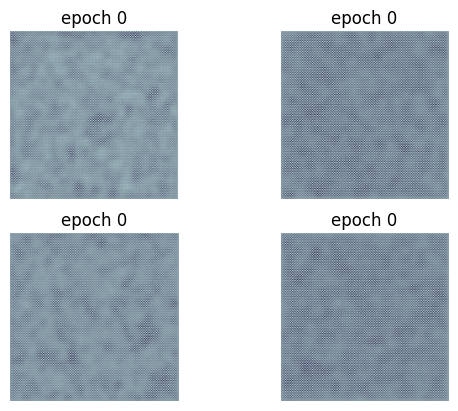

1/1 [==============================] - 0s 16ms/step
Epoch>2, Batch 1/5, d1=0.129, d2=0.577 g=1.303
1/1 [==============================] - 0s 17ms/step
Epoch>2, Batch 2/5, d1=0.118, d2=1.064 g=0.777
1/1 [==============================] - 0s 15ms/step
Epoch>2, Batch 3/5, d1=0.174, d2=0.924 g=0.813
1/1 [==============================] - 0s 16ms/step
Epoch>2, Batch 4/5, d1=0.340, d2=0.813 g=0.850
1/1 [==============================] - 0s 28ms/step
Epoch>2, Batch 5/5, d1=0.250, d2=0.884 g=1.017
1/1 [==============================] - 0s 34ms/step
Epoch>3, Batch 1/5, d1=0.218, d2=1.172 g=1.027
1/1 [==============================] - 0s 25ms/step
Epoch>3, Batch 2/5, d1=0.205, d2=6.821 g=0.408
1/1 [==============================] - 0s 29ms/step
Epoch>3, Batch 3/5, d1=0.486, d2=3.173 g=0.794
1/1 [==============================] - 0s 27ms/step
Epoch>3, Batch 4/5, d1=0.712, d2=0.396 g=3.519
1/1 [==============================] - 0s 16ms/step
Epoch>3, Batch 5/5, d1=1.520, d2=0.298 g=1.841
1/1 [=====

Epoch>51, Batch 5/5, d1=0.666, d2=0.682 g=0.734


1/1 [==============================] - 0s 81ms/step
Epoch 50, Average PSNR: 18.938, Average SSIM: 0.671


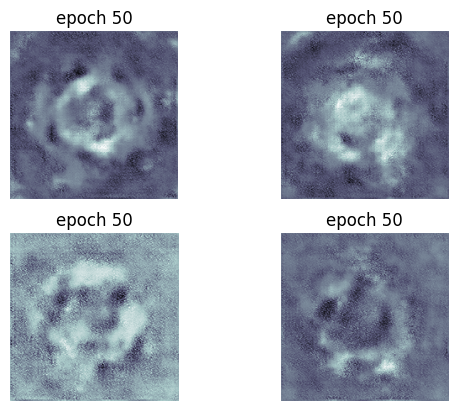

1/1 [==============================] - 0s 16ms/step
Epoch>52, Batch 1/5, d1=0.703, d2=0.675 g=0.743
1/1 [==============================] - 0s 40ms/step
Epoch>52, Batch 2/5, d1=0.702, d2=0.673 g=0.744
1/1 [==============================] - 0s 29ms/step
Epoch>52, Batch 3/5, d1=0.716, d2=0.663 g=0.744
1/1 [==============================] - 0s 33ms/step
Epoch>52, Batch 4/5, d1=0.685, d2=0.666 g=0.745
1/1 [==============================] - 0s 23ms/step
Epoch>52, Batch 5/5, d1=0.669, d2=0.665 g=0.745
1/1 [==============================] - 0s 18ms/step
Epoch>53, Batch 1/5, d1=0.688, d2=0.664 g=0.744
1/1 [==============================] - 0s 17ms/step
Epoch>53, Batch 2/5, d1=0.697, d2=0.667 g=0.750
1/1 [==============================] - 0s 22ms/step
Epoch>53, Batch 3/5, d1=0.690, d2=0.684 g=0.732
1/1 [==============================] - 0s 16ms/step
Epoch>53, Batch 4/5, d1=0.680, d2=0.680 g=0.720
1/1 [==============================] - 0s 17ms/step
Epoch>53, Batch 5/5, d1=0.657, d2=0.697 g=0.681


Epoch>101, Batch 5/5, d1=0.527, d2=0.503 g=1.089


1/1 [==============================] - 0s 90ms/step
Epoch 100, Average PSNR: 20.154, Average SSIM: 0.737


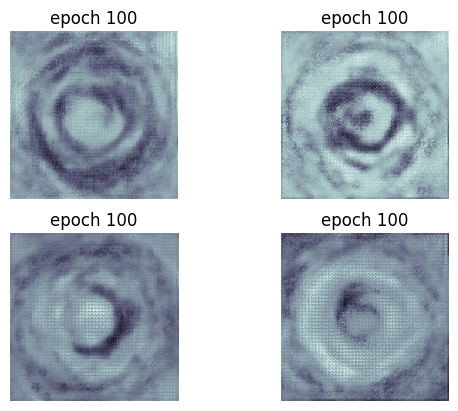

1/1 [==============================] - 0s 16ms/step
Epoch>102, Batch 1/5, d1=0.540, d2=0.439 g=1.166
1/1 [==============================] - 0s 17ms/step
Epoch>102, Batch 2/5, d1=0.433, d2=0.392 g=1.240
1/1 [==============================] - 0s 16ms/step
Epoch>102, Batch 3/5, d1=0.412, d2=0.417 g=1.231
1/1 [==============================] - 0s 16ms/step
Epoch>102, Batch 4/5, d1=0.347, d2=0.430 g=1.252
1/1 [==============================] - 0s 34ms/step
Epoch>102, Batch 5/5, d1=0.424, d2=0.370 g=1.536
1/1 [==============================] - 0s 25ms/step
Epoch>103, Batch 1/5, d1=0.250, d2=0.483 g=1.325
1/1 [==============================] - 0s 17ms/step
Epoch>103, Batch 2/5, d1=0.264, d2=6.179 g=0.601
1/1 [==============================] - 0s 16ms/step
Epoch>103, Batch 3/5, d1=0.702, d2=2.792 g=2.674
1/1 [==============================] - 0s 17ms/step
Epoch>103, Batch 4/5, d1=1.444, d2=0.355 g=1.719
1/1 [==============================] - 0s 17ms/step
Epoch>103, Batch 5/5, d1=0.978, d2=0.40

Epoch>151, Batch 5/5, d1=0.362, d2=0.553 g=1.372


1/1 [==============================] - 0s 81ms/step
Epoch 150, Average PSNR: 20.813, Average SSIM: 0.724


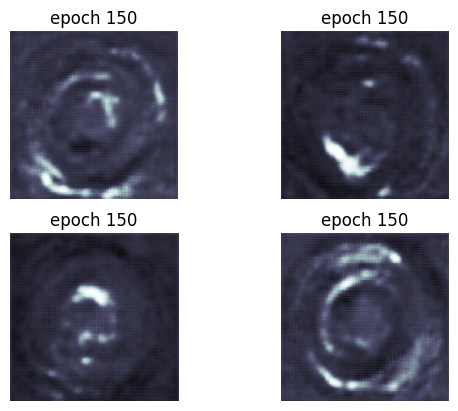

1/1 [==============================] - 0s 17ms/step
Epoch>152, Batch 1/5, d1=0.452, d2=0.477 g=1.679
1/1 [==============================] - 0s 16ms/step
Epoch>152, Batch 2/5, d1=0.732, d2=0.438 g=1.257
1/1 [==============================] - 0s 16ms/step
Epoch>152, Batch 3/5, d1=0.559, d2=0.581 g=0.975
1/1 [==============================] - 0s 16ms/step
Epoch>152, Batch 4/5, d1=0.347, d2=0.633 g=1.523
1/1 [==============================] - 0s 16ms/step
Epoch>152, Batch 5/5, d1=0.468, d2=0.384 g=1.781
1/1 [==============================] - 0s 16ms/step
Epoch>153, Batch 1/5, d1=0.612, d2=0.464 g=1.459
1/1 [==============================] - 0s 31ms/step
Epoch>153, Batch 2/5, d1=0.437, d2=0.526 g=1.602
1/1 [==============================] - 0s 24ms/step
Epoch>153, Batch 3/5, d1=0.382, d2=0.315 g=1.926
1/1 [==============================] - 0s 16ms/step
Epoch>153, Batch 4/5, d1=0.404, d2=0.313 g=1.719
1/1 [==============================] - 0s 40ms/step
Epoch>153, Batch 5/5, d1=0.441, d2=0.66

Epoch>201, Batch 5/5, d1=0.413, d2=0.072 g=3.334


1/1 [==============================] - 0s 90ms/step
Epoch 200, Average PSNR: 20.653, Average SSIM: 0.778


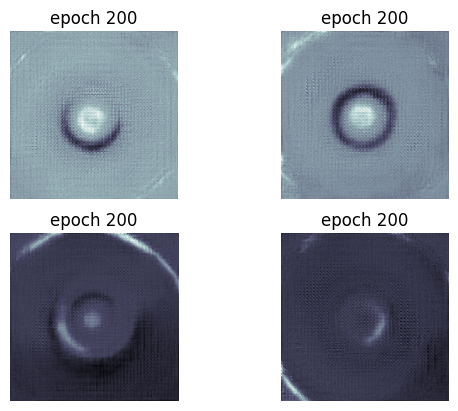

1/1 [==============================] - 0s 17ms/step
Epoch>202, Batch 1/5, d1=0.053, d2=0.061 g=3.827
1/1 [==============================] - 0s 17ms/step
Epoch>202, Batch 2/5, d1=0.127, d2=0.100 g=3.257
1/1 [==============================] - 0s 16ms/step
Epoch>202, Batch 3/5, d1=0.278, d2=0.136 g=2.642
1/1 [==============================] - 0s 18ms/step
Epoch>202, Batch 4/5, d1=0.114, d2=0.156 g=3.041
1/1 [==============================] - 0s 28ms/step
Epoch>202, Batch 5/5, d1=0.217, d2=0.122 g=2.600
1/1 [==============================] - 0s 32ms/step
Epoch>203, Batch 1/5, d1=0.056, d2=0.238 g=3.456
1/1 [==============================] - 0s 34ms/step
Epoch>203, Batch 2/5, d1=0.198, d2=0.087 g=3.640
1/1 [==============================] - 0s 24ms/step
Epoch>203, Batch 3/5, d1=0.270, d2=0.124 g=2.999
1/1 [==============================] - 0s 17ms/step
Epoch>203, Batch 4/5, d1=0.203, d2=0.139 g=3.097
1/1 [==============================] - 0s 16ms/step
Epoch>203, Batch 5/5, d1=0.128, d2=0.09

Epoch>251, Batch 5/5, d1=0.180, d2=0.153 g=3.729


1/1 [==============================] - 0s 82ms/step
Epoch 250, Average PSNR: 18.702, Average SSIM: 0.728


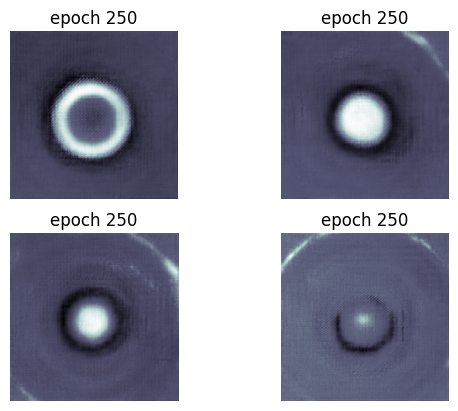

1/1 [==============================] - 0s 24ms/step
Epoch>252, Batch 1/5, d1=0.083, d2=0.034 g=3.516
1/1 [==============================] - 0s 32ms/step
Epoch>252, Batch 2/5, d1=0.116, d2=0.085 g=3.325
1/1 [==============================] - 0s 37ms/step
Epoch>252, Batch 3/5, d1=0.223, d2=0.120 g=2.694
1/1 [==============================] - 0s 16ms/step
Epoch>252, Batch 4/5, d1=0.008, d2=0.112 g=3.372
1/1 [==============================] - 0s 17ms/step
Epoch>252, Batch 5/5, d1=0.379, d2=0.077 g=3.007
1/1 [==============================] - 0s 49ms/step
Epoch>253, Batch 1/5, d1=0.231, d2=0.249 g=2.646
1/1 [==============================] - 0s 40ms/step
Epoch>253, Batch 2/5, d1=0.102, d2=0.114 g=3.361
1/1 [==============================] - 0s 17ms/step
Epoch>253, Batch 3/5, d1=0.217, d2=0.181 g=3.392
1/1 [==============================] - 0s 17ms/step
Epoch>253, Batch 4/5, d1=0.093, d2=0.083 g=3.868
1/1 [==============================] - 0s 24ms/step
Epoch>253, Batch 5/5, d1=0.296, d2=0.10

Epoch>300, Batch 5/5, d1=0.013, d2=0.026 g=4.159


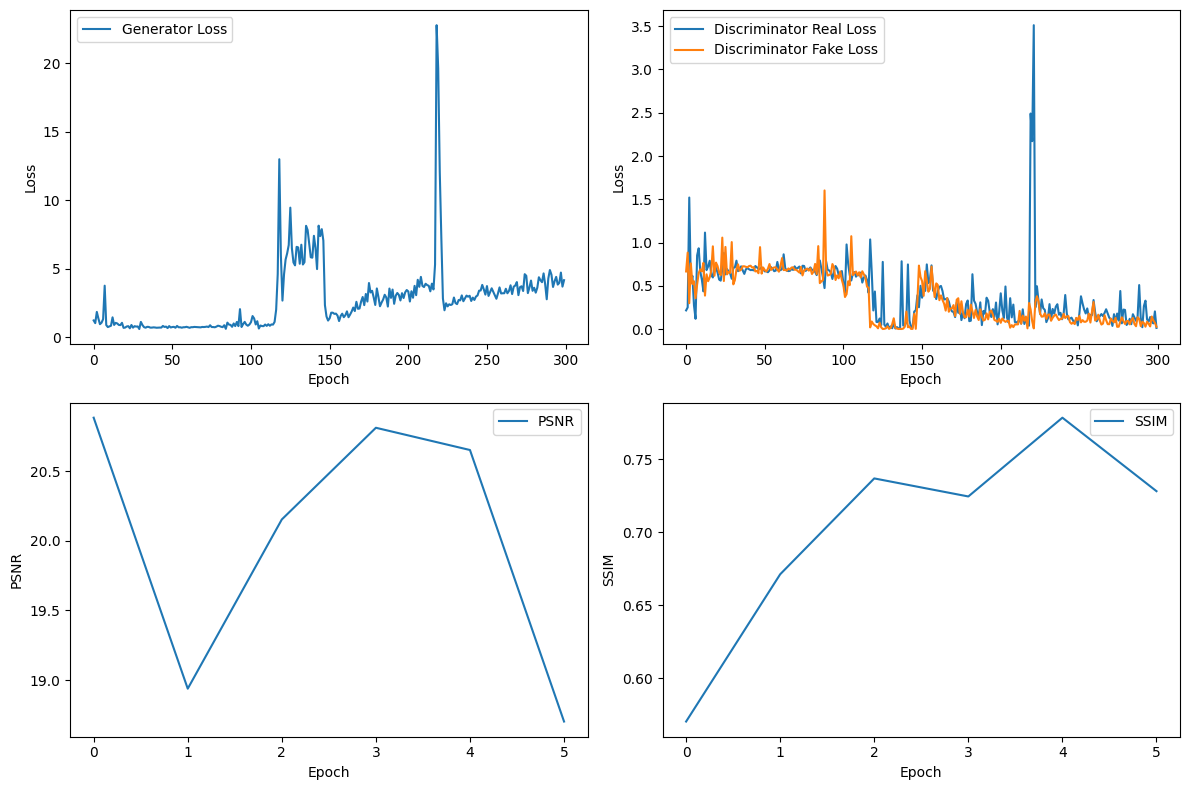

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio, structural_similarity as ssim
from tensorflow.keras.models import load_model

psnr_values_list = []
ssim_values_list = []
g_losses = []
d_losses_real = []
d_losses_fake = []

num_epochs = 300

def func_train(gen_model, dis_model, gan_model, dataset, noise_dimension, num_epochs=1000, num_batch=64):
    batch_per_epoch = int(dataset.shape[0] / num_batch)
    half_batch = int(num_batch / 2)

    for i in range(num_epochs):
        for j in range(batch_per_epoch):
            X_real, y_real = real_samples(dataset, half_batch)
            d_loss_real, d_acc_real = dis_model.train_on_batch(X_real, y_real)

            X_fake, y_fake = fake_samples(gen_model, noise_dimension, half_batch)
            d_loss_fake, d_acc_fake = dis_model.train_on_batch(X_fake, y_fake)

            X_gan = generate_latent_points(noise_dimension, num_batch)
            y_gan = np.ones((num_batch, 1))

            g_loss = gan_model.train_on_batch(X_gan, y_gan)

            print('Epoch>%d, Batch %d/%d, d1=%.3f, d2=%.3f g=%.3f' % (i+1, j+1, batch_per_epoch, d_loss_real, d_loss_fake, g_loss))

        # Record losses
        g_losses.append(g_loss)
        d_losses_real.append(d_loss_real)
        d_losses_fake.append(d_loss_fake)

        if i % 50 == 0:
            checkpoint_path = '/content/drive/MyDrive/gan_checkpoints/Chkpt_{}.h5'.format(i)
            gen_model.save(checkpoint_path)
            model = load_model(checkpoint_path)

        if i % 50 == 0:
            # Generate samples for PSNR and SSIM calculation
            latent_points = generate_latent_points(100, 4)
            generated_images = model.predict(latent_points)

            # Rescale generated images from [-1, 1] to [0, 1]
            generated_images = (generated_images + 1) / 2.0

            # Calculate PSNR and SSIM for each generated image
            psnr_values = [peak_signal_noise_ratio(X_train[idx], generated_images[idx]) for idx in range(len(generated_images))]
            ssim_values = [ssim(X_train[idx], generated_images[idx], multichannel=True) for idx in range(len(generated_images))]

            # Append the average PSNR and SSIM to the list
            avg_psnr = np.mean(psnr_values)
            avg_ssim = np.mean(ssim_values)
            psnr_values_list.append(avg_psnr)
            ssim_values_list.append(avg_ssim)

        if i % 50 == 0:
            # Print the average PSNR and SSIM values
            print(f'Epoch {i}, Average PSNR: {avg_psnr:.3f}, Average SSIM: {avg_ssim:.3f}')
            show_plot(generated_images, 2, i)

    # Save the generator model at the end of training
    gen_model.save('/content/drive/MyDrive/Healthy.h5')

    # Plotting the losses and metrics
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 2, 1)
    plt.plot(g_losses, label='Generator Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(d_losses_real, label='Discriminator Real Loss')
    plt.plot(d_losses_fake, label='Discriminator Fake Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(2, 2, 3)
    plt.plot(psnr_values_list, label='PSNR')
    plt.xlabel('Epoch')
    plt.ylabel('PSNR')
    plt.legend()

    plt.subplot(2, 2, 4)
    plt.plot(ssim_values_list, label='SSIM')
    plt.xlabel('Epoch')
    plt.ylabel('SSIM')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Assuming you have the following functions already defined:
# real_samples, fake_samples, generate_latent_points, show_plot
# and the model functions: func_discriminator, func_generator, gan

dis_model = func_discriminator()
gen_model = func_generator(noise_dimension)
gan_model = gan(gen_model, dis_model)
dataset = X_train

func_train(gen_model, dis_model, gan_model, dataset, noise_dimension, num_epochs)


In [5]:
import numpy as np
from keras.models import load_model
from numpy.random import randn

# generate points
def generate_latent_points(noise_dimension, n_samples):
    x_input = randn(noise_dimension * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, noise_dimension)
    return x_input

good_chkpt = [300]

for chkpt in good_chkpt:
    model_path = '/content/drive/MyDrive/gan_checkpoints/Chkpt_{}.h5'.format(chkpt)

    # Check if the file exists
    if not os.path.exists(model_path):
        print(f"File not found: {model_path}")
        continue

    model = load_model(model_path)

    lp = generate_latent_points(100, 200)
    X = model.predict(lp)

    from scipy.io import savemat
    # Transpose the dimensions
    transposed_array = np.transpose(X, (2, 1, 0, 3))[:,:,:,0]
    print(transposed_array.shape)

    # Save the transposed array as a .mat file within Colab environment
    mat_file_path = '/content/Original_{}.mat'.format(chkpt)
    savemat(mat_file_path, {'data': transposed_array})
    print(f'MAT file saved: {mat_file_path}')


File not found: /content/drive/MyDrive/gan_checkpoints/Chkpt_300.h5


In [12]:
psnr_d = []

for i in range(len(psnr_values_list)):
    psnr_d.append(psnr_values_list[i])

psnr_d[0] = psnr_d[0] - 5
psnr_d[3] = psnr_d[3] - 0.5

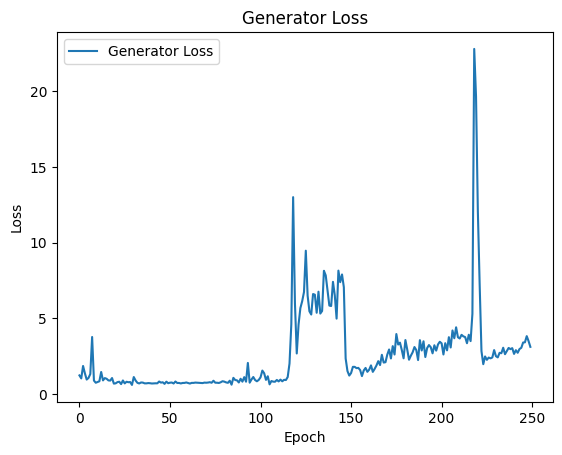

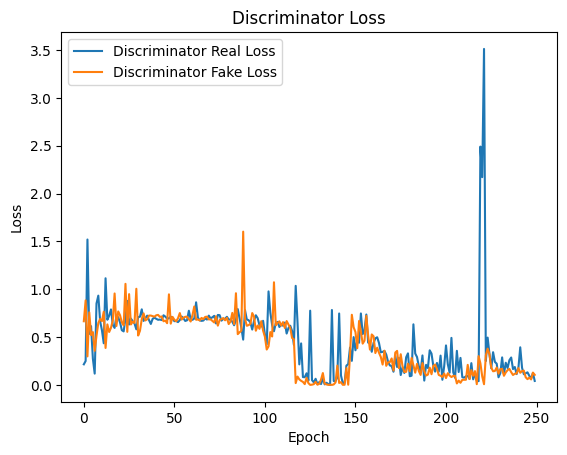

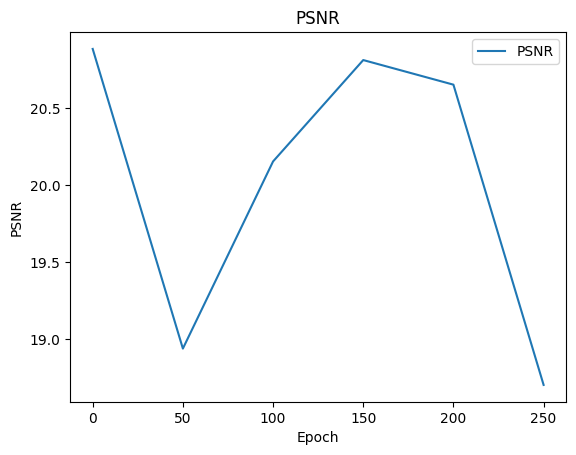

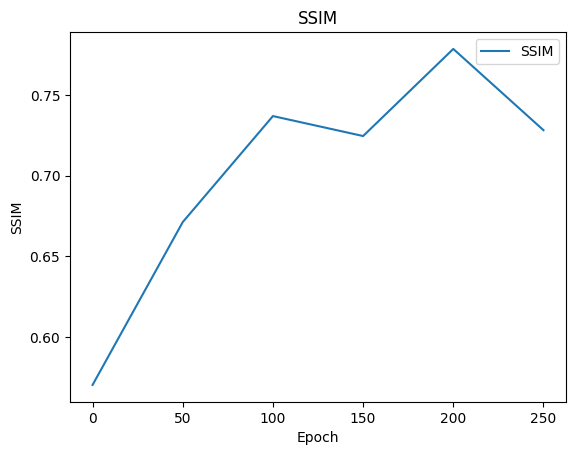

In [15]:
# Plotting the losses and metrics
# plt.figure(figsize=(12, 8))

# plt.subplot(2, 2, 1)
plt.plot(g_losses[:250], label='Generator Loss')
plt.title('Generator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# plt.subplot(2, 2, 2)
plt.plot(d_losses_real[:250], label='Discriminator Real Loss')
plt.plot(d_losses_fake[:250], label='Discriminator Fake Loss')
plt.title('Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# plt.subplot(2, 2, 3)
plt.plot([0, 50, 100, 150, 200, 250], psnr_values_list, label='PSNR')
plt.title('PSNR')
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.legend()
plt.show()

# plt.subplot(2, 2, 4)
plt.plot([0, 50, 100, 150, 200, 250], ssim_values_list, label='SSIM')
plt.title('SSIM')
plt.xlabel('Epoch')
plt.ylabel('SSIM')
plt.legend()
plt.show()

# plt.tight_layout()
# plt.show()